# Imports

In [176]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus
from IPython.display import Image
import statistics
import numpy as np
from utilities import get_path

In [69]:
DATA_PATH = get_path()

In [70]:
def get_metrics(target, pred, target_labels, set_kind, verbose=True):
  print('Accuracy', metrics.accuracy_score(target, pred))
  if verbose:
    print(f'Precision {set_kind} set ', metrics.precision_score(target, pred, average='weighted'))
    print(f'Recall {set_kind} set ', metrics.recall_score(target, pred, average='weighted'))
    print(f'F1 score {set_kind} set ', metrics.f1_score(target, pred, average='weighted'))
    print(f'Support {set_kind} set ', metrics.precision_recall_fscore_support(target, pred))

  print(metrics.classification_report(target, pred, target_names = target_labels))

In [71]:
def confusion_matrix(target, pred):
  cm = metrics.confusion_matrix(target, pred)
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show() 

In [72]:
def cross_validation(model, tr, target):
  cv_scores = cross_validate(model, tr, target, cv=5, return_train_score = True, scoring=['accuracy','recall','f1'])

  for k in cv_scores.keys():
      cv_scores[k] = statistics.mean(cv_scores[k])
  return cv_scores
#  print('Cross Validation Validation score ', statistics.mean(cv_scores['test_score']))
#  print('Cross Validation Train score ', statistics.mean(cv_scores['train_score']))

In [73]:
df_indicators = pd.read_csv(DATA_PATH + 'indicators_clean.csv', sep='#')
#df_tweets_ind = pd.read_csv(DATA_PATH+'tweets_with_indicators.csv', sep='#')
df_users = pd.read_csv(DATA_PATH + 'users_clean.csv', sep='#')

In [74]:
df_users.id = df_users.id.astype(str)
df_merge = df_users.merge(df_indicators, left_on='id', right_on='user_id', how='left')

In [75]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                11508 non-null  object 
 1   name                              11507 non-null  object 
 2   lang                              11508 non-null  object 
 3   bot                               11508 non-null  int64  
 4   user_subscription                 11508 non-null  object 
 5   statuses_count                    11508 non-null  float64
 6   user_subscription_in_secs         11508 non-null  int64  
 7   user_id                           11504 non-null  object 
 8   n_tweets                          11504 non-null  float64
 9   2012_tweets                       11504 non-null  float64
 10  2013_tweets                       11504 non-null  float64
 11  2014_tweets                       11504 non-null  float64
 12  2015

In [76]:
# Drop variables which aren't useful for classification purposes
df_merge.drop(columns=['id', 'name', 'user_subscription', 'user_id'], inplace=True)
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 37 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   lang                              11508 non-null  object 
 1   bot                               11508 non-null  int64  
 2   statuses_count                    11508 non-null  float64
 3   user_subscription_in_secs         11508 non-null  int64  
 4   n_tweets                          11504 non-null  float64
 5   2012_tweets                       11504 non-null  float64
 6   2013_tweets                       11504 non-null  float64
 7   2014_tweets                       11504 non-null  float64
 8   2015_tweets                       11504 non-null  float64
 9   2016_tweets                       11504 non-null  float64
 10  2017_tweets                       11504 non-null  float64
 11  2018_tweets                       11504 non-null  float64
 12  2019

In [77]:
def discretize_column(df, column_name):
    #get the unique variable's values
    values = df[column_name].unique()

    d = dict( (el, i) for i, el in enumerate(values) )

    df[column_name + '_discr'] = df[column_name].apply(lambda x: d[x])

In [78]:
# Convert lang column to numbers (e.g. en = 0, it = 1, etc.)
discretize_column(df_merge, 'lang')

# Drop original lang column
df_merge.drop(columns=['lang'], inplace=True)
df_merge

,bot,statuses_count,user_subscription_in_secs,n_tweets,2012_tweets,2013_tweets,2014_tweets,2015_tweets,2016_tweets,2017_tweets,...,num_hashtags_mean,num_hashtags_std,num_urls_mean,num_urls_std,num_mentions_mean,num_mentions_std,tweeting_regularity,max_daily_tweets,n_tweets_density,lang_discr
0,1,76.0,1550858442000000000,119.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.109244,0.465594,0.000000,0.000000,0.294118,0.457572,2.458470,17.0,7.424137e-10,0
1,0,54.0,1551150152000000000,106.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.028302,0.166622,0.000000,0.000000,0.358491,0.481835,2.504295,18.0,6.742423e-10,0
2,1,3.0,1430377796000000000,3.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060681,2.0,7.349446e-12,0
3,1,50.0,1484707758000000000,1269.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.084318,0.469897,0.023641,0.151987,0.007092,0.108533,1.657428,130.0,1.231306e-09,1
4,0,7085.0,1560886221000000000,3234.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.132962,0.415753,0.000928,0.030448,0.528139,0.634101,7.637613,47.0,1.014485e-08,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11503,0,1126.0,1575033362000000000,996.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.216867,0.614037,0.027108,0.168553,0.745984,0.860486,4.828845,52.0,6.419927e-09,0
11504,0,3024.0,1524798118000000000,1854.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.129989,0.438114,0.100324,0.302303,0.544229,0.720479,4.181057,83.0,2.528313e-09,0
11505,0,6.0,1427648484000000000,6.0,0.0,0.0,0.0,1.0,2.0,3.0,...,0.333333,0.516398,0.666667,0.516398,0.333333,0.516398,0.919460,2.0,6.221464e-12,4
11506,1,42.0,1552445053000000000,95.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.010526,0.102598,0.000000,0.000000,0.400000,0.492497,2.421923,10.0,6.613163e-10,0


In [79]:
# Eliminate NaN values
df_merge = df_merge.fillna(value=0)

In [80]:
df_merge.replace(-np.inf, np.finfo(np.float32).min, inplace=True)

In [81]:
df_merge.replace(np.inf, np.finfo(np.float32).max, inplace=True)

In [82]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 37 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   bot                               11508 non-null  int64  
 1   statuses_count                    11508 non-null  float64
 2   user_subscription_in_secs         11508 non-null  int64  
 3   n_tweets                          11508 non-null  float64
 4   2012_tweets                       11508 non-null  float64
 5   2013_tweets                       11508 non-null  float64
 6   2014_tweets                       11508 non-null  float64
 7   2015_tweets                       11508 non-null  float64
 8   2016_tweets                       11508 non-null  float64
 9   2017_tweets                       11508 non-null  float64
 10  2018_tweets                       11508 non-null  float64
 11  2019_tweets                       11508 non-null  float64
 12  2020

In [92]:
tr, ts, tr_target, ts_target = train_test_split(df_merge.drop(columns='bot'), df_merge['bot'], stratify =df_merge['bot'], test_size=0.20)

In [93]:
print(f'Number of samples in Training set:', len(tr))
print(f'Number of samples in Test set:', len(ts))

Number of samples in Training set: 7364
Number of samples in Validation set: 1842
Number of samples in Test set: 2302


# Decision Tree

In [106]:
parameters = {
    'criterion': ['gini','entropy','log_loss'],
    'splitter': ['random','best'],
    'max_depth': [4,8,16,32,64,None],
    'min_samples_split': [2,4,8,16,32],
    'min_samples_leaf': [1,2,4,8],
    'max_features': ['sqrt', 'log2', None],
    'random_state': [42],
    'max_leaf_nodes': [None],
    'min_impurity_decrease': [0.0, 1e-2],
}

d_tree = DecisionTreeClassifier()

In [123]:
gs = GridSearchCV(d_tree, param_grid=parameters, scoring=['accuracy','precision', 'recall', 'f1'], verbose=3, refit=False, n_jobs=6, return_train_score=True)

In [124]:
gs.fit(tr, tr_target)

Fitting 5 folds for each of 4320 candidates, totalling 21600 fits


C:\Users\al\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
7200 fits failed out of a total of 21600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7200 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

  warnings.warn(some_fits_failed_message

GridSearchCV(estimator=DecisionTreeClassifier(max_depth=10, min_samples_leaf=3,
                                              min_samples_split=5),
             n_jobs=6,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [4, 8, 16, 32, 64, None],
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [None],
                         'min_impurity_decrease': [0.0, 0.01],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'min_samples_split': [2, 4, 8, 16, 32],
                         'random_state': [42], 'splitter': ['random', 'best']},
             refit=False, return_train_score=True,
             scoring=['accuracy', 'precision', 'recall', 'f1'], verbose=3)

In [125]:
results_df = pd.DataFrame(gs.cv_results_)
results_df.to_csv("classification/decision_tree/gs_results.csv")

In [128]:
pd.set_option("display.max_colwidth", None)
results_df.sort_values(by='mean_test_f1',ascending=False)[['params','mean_train_accuracy','mean_train_precision','mean_train_recall','mean_train_f1',
            'mean_test_accuracy','mean_test_precision','mean_test_recall','mean_test_f1']]


,params,mean_train_accuracy,mean_train_precision,mean_train_recall,mean_train_f1,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
2879,"{'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 8, 'min_samples_split': 32, 'random_state': 42, 'splitter': 'best'}",0.85918,0.794242,0.99208,0.882203,0.859178,0.794396,0.992079,0.882259
2849,"{'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 1, 'min_samples_split': 32, 'random_state': 42, 'splitter': 'best'}",0.85918,0.794242,0.99208,0.882203,0.859178,0.794396,0.992079,0.882259
1657,"{'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 2, 'min_samples_split': 16, 'random_state': 42, 'splitter': 'best'}",0.85918,0.794242,0.99208,0.882203,0.859178,0.794396,0.992079,0.882259
1659,"{'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 2, 'min_samples_split': 32, 'random_state': 42, 'splitter': 'best'}",0.85918,0.794242,0.99208,0.882203,0.859178,0.794396,0.992079,0.882259
1661,"{'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 4, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}",0.85918,0.794242,0.99208,0.882203,0.859178,0.794396,0.992079,0.882259
...,...,...,...,...,...,...,...,...,...
4315,"{'criterion': 'log_loss', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 8, 'min_samples_split': 8, 'random_state': 42, 'splitter': 'best'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4316,"{'criterion': 'log_loss', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 8, 'min_samples_split': 16, 'random_state': 42, 'splitter': 'random'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4317,"{'criterion': 'log_loss', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 8, 'min_samples_split': 16, 'random_state': 42, 'splitter': 'best'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4318,"{'criterion': 'log_loss', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 8, 'min_samples_split': 32, 'random_state': 42, 'splitter': 'random'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [146]:
params = results_df.sort_values(by='mean_test_f1',ascending=False)['params'].head(1).reset_index().loc[0][1]

In [148]:
d_tree = DecisionTreeClassifier(**params)
d_tree = d_tree.fit(tr, tr_target)

In [150]:
dot_data = export_graphviz(d_tree, out_file=None, feature_names=list(ts.columns), filled=True, rounded=True, class_names=['genuine user','bot'])
graph = pydotplus.graph_from_dot_data(dot_data)
with open('./classification/decision_tree/dtree_graph.png','wb') as png:
    png.write(Image(graph.create_png()).data)

Accuracy 0.8514335360556038
Precision test set  0.8800523354494986
Recall test set  0.8514335360556038
F1 score test set  0.8469991597026366
Support test set  (array([0.98807947, 0.78474467]), array([0.69138091, 0.99264105]), array([0.81352236, 0.8765343 ]), array([1079, 1223], dtype=int64))
              precision    recall  f1-score   support

genuine_user       0.99      0.69      0.81      1079
         bot       0.78      0.99      0.88      1223

    accuracy                           0.85      2302
   macro avg       0.89      0.84      0.85      2302
weighted avg       0.88      0.85      0.85      2302



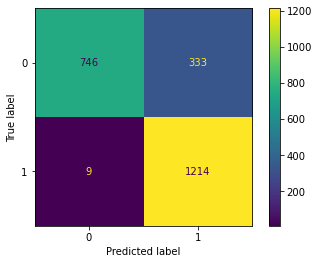

In [151]:
ts_pred = d_tree.predict(ts)
get_metrics(ts_target, ts_pred, ['genuine_user','bot'],'test')
confusion_matrix(ts_target, ts_pred)

TODO: scatter plots

In [152]:
# Example
plt.scatter(df_users[df_users['bot'] == 0]['created_at_conv'], 
            df_users[df_users['bot'] == 0]['lang'], color='g', marker='*', label='Non-bot user')
plt.scatter(df_users[df_users['bot'] == 1]['created_at_conv'], 
            df_users[df_users['bot'] == 1]['lang'], color='r', marker='2', label='Bot user')
plt.xlabel('created_at')
plt.ylabel('lang')
plt.legend()
plt.show()

KeyError: 'created_at_conv'

# Naive Bayes

In [172]:
multinomial_nb = MultinomialNB()
labels = ['genuine user','bot']
parameters = {
    'alpha':[0.25,0.5,0.75,1, 2],
    'fit_prior': [True, False]
}

gs = GridSearchCV(multinomial_nb, param_grid=parameters, scoring=['accuracy','precision', 'recall', 'f1'], verbose=3, refit=False, n_jobs=6, return_train_score=True)

In [173]:
gs.fit(tr, tr_target)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\al\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\naive_bayes.py", line 690, in fit
    self._count(X, Y)
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\naive_bayes.py", line 863, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\ut

GridSearchCV(estimator=MultinomialNB(), n_jobs=6,
             param_grid={'alpha': [0.25, 0.5, 0.75, 1, 2],
                         'fit_prior': [True, False]},
             refit=False, return_train_score=True,
             scoring=['accuracy', 'precision', 'recall', 'f1'], verbose=3)

In [174]:
results_df = pd.DataFrame(gs.cv_results_)
results_df.to_csv("classification/mn_naive_bayes/gs_results.csv")

In [175]:
results_df[
    ['params', 'mean_train_accuracy', 'mean_train_precision', 'mean_train_recall', 'mean_train_f1',
     'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1']]

,params,mean_train_accuracy,mean_train_precision,mean_train_recall,mean_train_f1,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,"{'alpha': 0.25, 'fit_prior': True}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"{'alpha': 0.25, 'fit_prior': False}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"{'alpha': 0.5, 'fit_prior': True}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"{'alpha': 0.5, 'fit_prior': False}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"{'alpha': 0.75, 'fit_prior': True}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"{'alpha': 0.75, 'fit_prior': False}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,"{'alpha': 1, 'fit_prior': True}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,"{'alpha': 1, 'fit_prior': False}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,"{'alpha': 2, 'fit_prior': True}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,"{'alpha': 2, 'fit_prior': False}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Random Forest

In [61]:
parameters = {
    "n_estimators": range(50,500,100),
    "criterion": ["gini","entropy","log_loss"],
    "max_depth": [None] + list(range(5,100,10)),
    "min_samples_split": [2,4,8,16,32,64],
    "min_samples_leaf": [2,4,8,16,32,64,128],
    "max_features":["auto","sqrt","log2",None],
    "max_leaf_nodes":[None] + list(range(1,10,2)),
    "min_impurity_decrease": 0.1 * np.array(range(1,5))
}


'  \n"max_depth": [None] + list(range(5,100,10)),\n    #"min_samples_split": [2,4,8,16,32,64],\n    "min_samples_split": [2,16,64],\n    #"min_samples_leaf": [2,4,8,16,32,64,128],\n    "min_samples_leaf": [2,16,64,128],\n    "max_features":["auto","sqrt","log2",None],\n    "max_leaf_nodes":[None] + list(range(1,10,2)),\n    "min_impurity_decrease": 0.1 * np.array(range(1,5))\n'

In [63]:
r_forest = RandomForestClassifier()
gs = GridSearchCV(r_forest,param_grid=parameters, scoring=['accuracy','recall','f1'], verbose=3,refit=False)

In [64]:
gs.fit(tr,tr_target)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END criterion=gini, n_estimators=50; accuracy: (test=0.853) f1: (test=0.877) recall: (test=0.985) total time=   0.6s
[CV 2/5] END criterion=gini, n_estimators=50; accuracy: (test=0.856) f1: (test=0.879) recall: (test=0.987) total time=   0.5s
[CV 3/5] END criterion=gini, n_estimators=50; accuracy: (test=0.851) f1: (test=0.876) recall: (test=0.987) total time=   0.6s
[CV 4/5] END criterion=gini, n_estimators=50; accuracy: (test=0.845) f1: (test=0.872) recall: (test=0.989) total time=   0.5s
[CV 5/5] END criterion=gini, n_estimators=50; accuracy: (test=0.862) f1: (test=0.883) recall: (test=0.982) total time=   0.5s
[CV 1/5] END criterion=gini, n_estimators=150; accuracy: (test=0.855) f1: (test=0.879) recall: (test=0.990) total time=   1.5s
[CV 2/5] END criterion=gini, n_estimators=150; accuracy: (test=0.852) f1: (test=0.876) recall: (test=0.985) total time=   1.5s
[CV 3/5] END criterion=gini, n_estimators=150; accuracy

C:\Users\al\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\al\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\al\anaconda3\lib\site-packages\joblib\parallel.p

GridSearchCV(estimator=RandomForestClassifier(min_samples_leaf=4,
                                              min_samples_split=5,
                                              n_estimators=200),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'n_estimators': range(50, 500, 100)},
             refit=False, scoring=['accuracy', 'recall', 'f1'], verbose=3)

In [65]:
pd.DataFrame(gs.cv_results_).to_csv("random_forest_gs_results.csv")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_n_estimators,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.608557,0.064217,0.026259,0.008374,gini,50,"{'criterion': 'gini', 'n_estimators': 50}",0.853420,0.856056,0.851168,...,0.002421,10,0.877161,0.879381,0.875793,0.871564,0.883165,0.877413,0.003843,10
1,1.539208,0.027788,0.051781,0.002160,gini,150,"{'criterion': 'gini', 'n_estimators': 150}",0.854506,0.851711,0.854427,...,0.004618,8,0.878513,0.875965,0.878513,0.874887,0.885095,0.878595,0.003547,7
2,2.552853,0.081574,0.081552,0.002973,gini,250,"{'criterion': 'gini', 'n_estimators': 250}",0.855049,0.852254,0.853884,...,0.004260,7,0.878802,0.876364,0.878446,0.872695,0.886427,0.878546,0.004498,8
3,3.694177,0.132688,0.116957,0.007010,gini,350,"{'criterion': 'gini', 'n_estimators': 350}",0.855592,0.853884,0.852797,...,0.003142,5,0.879420,0.877672,0.877320,0.873480,0.887045,0.878987,0.004471,6
4,4.539945,0.106185,0.147498,0.004690,gini,450,"{'criterion': 'gini', 'n_estimators': 450}",0.855049,0.852797,0.854970,...,0.004597,1,0.878912,0.876650,0.879349,0.875000,0.887149,0.879412,0.004176,4
5,0.747248,0.010979,0.020513,0.000602,entropy,50,"{'criterion': 'entropy', 'n_estimators': 50}",0.855049,0.848995,0.853341,...,0.006065,9,0.878802,0.873521,0.878049,0.874381,0.885291,0.878009,0.004170,9
6,2.154744,0.074342,0.050961,0.000738,entropy,150,"{'criterion': 'entropy', 'n_estimators': 150}",0.855049,0.853341,0.855513,...,0.004260,3,0.878912,0.877273,0.879638,0.874887,0.887760,0.879694,0.004351,1
7,5.432840,2.369643,0.115296,0.042988,entropy,250,"{'criterion': 'entropy', 'n_estimators': 250}",0.855592,0.852254,0.856056,...,0.004355,4,0.879310,0.876251,0.879819,0.875788,0.886228,0.879479,0.003734,3
8,9.816453,0.958650,0.249620,0.047486,entropy,350,"{'criterion': 'entropy', 'n_estimators': 350}",0.855592,0.853341,0.856056,...,0.005583,2,0.879420,0.876937,0.880145,0.875506,0.886123,0.879626,0.003653,2
9,12.076668,2.160699,0.281048,0.082666,entropy,450,"{'criterion': 'entropy', 'n_estimators': 450}",0.855592,0.852797,0.855513,...,0.005471,6,0.879420,0.876538,0.879638,0.874887,0.885095,0.879115,0.003482,5


In [ ]:
ts_pred = d_tree.predict(ts)
get_metrics(ts_target, ts_pred, ['genuine_user','bot'],'test')
confusion_matrix(ts_target, ts_pred)

In [125]:
results_df = pd.DataFrame(gs.cv_results_)
results_df.to_csv("classification/random_forest/gs_results.csv")

In [128]:
results_df.sort_values(by='mean_test_f1',ascending=False)[['params','mean_train_accuracy','mean_train_precision','mean_train_recall','mean_train_f1',
            'mean_test_accuracy','mean_test_precision','mean_test_recall','mean_test_f1']]


,params,mean_train_accuracy,mean_train_precision,mean_train_recall,mean_train_f1,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
2879,"{'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 8, 'min_samples_split': 32, 'random_state': 42, 'splitter': 'best'}",0.85918,0.794242,0.99208,0.882203,0.859178,0.794396,0.992079,0.882259
2849,"{'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 1, 'min_samples_split': 32, 'random_state': 42, 'splitter': 'best'}",0.85918,0.794242,0.99208,0.882203,0.859178,0.794396,0.992079,0.882259
1657,"{'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 2, 'min_samples_split': 16, 'random_state': 42, 'splitter': 'best'}",0.85918,0.794242,0.99208,0.882203,0.859178,0.794396,0.992079,0.882259
1659,"{'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 2, 'min_samples_split': 32, 'random_state': 42, 'splitter': 'best'}",0.85918,0.794242,0.99208,0.882203,0.859178,0.794396,0.992079,0.882259
1661,"{'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 4, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}",0.85918,0.794242,0.99208,0.882203,0.859178,0.794396,0.992079,0.882259
...,...,...,...,...,...,...,...,...,...
4315,"{'criterion': 'log_loss', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 8, 'min_samples_split': 8, 'random_state': 42, 'splitter': 'best'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4316,"{'criterion': 'log_loss', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 8, 'min_samples_split': 16, 'random_state': 42, 'splitter': 'random'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4317,"{'criterion': 'log_loss', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 8, 'min_samples_split': 16, 'random_state': 42, 'splitter': 'best'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4318,"{'criterion': 'log_loss', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 8, 'min_samples_split': 32, 'random_state': 42, 'splitter': 'random'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [148]:
params = results_df.sort_values(by='mean_test_f1',ascending=False)['params'].head(1).reset_index().loc[0][1]
r_forest = RandomForestClassifier(**params)
r_forest = r_forest.fit(tr, tr_target)

In [ ]:
ts_pred = r_forest.predict(ts)
get_metrics(ts_target, ts_pred, ['genuine_user', 'bot'], 'test')
confusion_matrix(ts_target, ts_pred)

# Adaboost

In [179]:
parameters = {
    'base_estimator': [DecisionTreeClassifier(max_depth=4)],
    'n_estimators': [8,16,32,64,128],
    'learning_rate': [1e-2, 1e-1, 1, 1e1, 1e2],
    'algorithm': ['SAMME','SAMME.R'],
}

adaboost = AdaBoostClassifier()

In [180]:
gs = GridSearchCV(adaboost, param_grid=parameters, scoring=['accuracy','precision','recall','f1'], verbose=3,refit=False)

In [181]:
gs.fit(tr)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END algorithm=SAMME, base_estimator=DecisionTreeClassifier(max_depth=4), learning_rate=0.01, n_estimators=8, random_state=42; accuracy: (test=nan) f1: (test=nan) recall: (test=nan) total time=   0.0s
[CV 2/5] END algorithm=SAMME, base_estimator=DecisionTreeClassifier(max_depth=4), learning_rate=0.01, n_estimators=8, random_state=42; accuracy: (test=nan) f1: (test=nan) recall: (test=nan) total time=   0.0s
[CV 3/5] END algorithm=SAMME, base_estimator=DecisionTreeClassifier(max_depth=4), learning_rate=0.01, n_estimators=8, random_state=42; accuracy: (test=nan) f1: (test=nan) recall: (test=nan) total time=   0.0s
[CV 4/5] END algorithm=SAMME, base_estimator=DecisionTreeClassifier(max_depth=4), learning_rate=0.01, n_estimators=8, random_state=42; accuracy: (test=nan) f1: (test=nan) recall: (test=nan) total time=   0.0s
[CV 5/5] END algorithm=SAMME, base_estimator=DecisionTreeClassifier(max_depth=4), learning_rate=0.01, 

C:\Users\al\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
250 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
250 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 678, in _fit_and_score
    estimator.fit(X_train, **fit_params)
TypeError: fit() missing 1 required positional argument: 'y'

  warnings.warn(some_fits_failed_message, FitFailedWarning)
C:\Users\al\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan

GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'base_estimator': [DecisionTreeClassifier(max_depth=4)],
                         'learning_rate': [0.01, 0.1, 1, 10.0, 100.0],
                         'n_estimators': [8, 16, 32, 64, 128],
                         'random_state': [42]},
             refit=False, scoring=['accuracy', 'recall', 'f1'], verbose=3)

In [182]:
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_base_estimator,param_learning_rate,param_n_estimators,param_random_state,params,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.002901,0.000803,0.0,0.0,SAMME,DecisionTreeClassifier(max_depth=4),0.01,8,42,"{'algorithm': 'SAMME', 'base_estimator': DecisionTreeClassifier(max_depth=4), 'learning_rate': 0.01, 'n_estimators': 8, 'random_state': 42}",...,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,0.002055,0.000629,0.0,0.0,SAMME,DecisionTreeClassifier(max_depth=4),0.01,16,42,"{'algorithm': 'SAMME', 'base_estimator': DecisionTreeClassifier(max_depth=4), 'learning_rate': 0.01, 'n_estimators': 16, 'random_state': 42}",...,NaN,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27
2,0.002208,0.001298,0.0,0.0,SAMME,DecisionTreeClassifier(max_depth=4),0.01,32,42,"{'algorithm': 'SAMME', 'base_estimator': DecisionTreeClassifier(max_depth=4), 'learning_rate': 0.01, 'n_estimators': 32, 'random_state': 42}",...,NaN,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28
3,0.002409,0.001351,0.0,0.0,SAMME,DecisionTreeClassifier(max_depth=4),0.01,64,42,"{'algorithm': 'SAMME', 'base_estimator': DecisionTreeClassifier(max_depth=4), 'learning_rate': 0.01, 'n_estimators': 64, 'random_state': 42}",...,NaN,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29
4,0.001309,0.000407,0.0,0.0,SAMME,DecisionTreeClassifier(max_depth=4),0.01,128,42,"{'algorithm': 'SAMME', 'base_estimator': DecisionTreeClassifier(max_depth=4), 'learning_rate': 0.01, 'n_estimators': 128, 'random_state': 42}",...,NaN,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30
5,0.002921,0.001494,0.0,0.0,SAMME,DecisionTreeClassifier(max_depth=4),0.1,8,42,"{'algorithm': 'SAMME', 'base_estimator': DecisionTreeClassifier(max_depth=4), 'learning_rate': 0.1, 'n_estimators': 8, 'random_state': 42}",...,NaN,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31
6,0.003811,0.001874,0.0,0.0,SAMME,DecisionTreeClassifier(max_depth=4),0.1,16,42,"{'algorithm': 'SAMME', 'base_estimator': DecisionTreeClassifier(max_depth=4), 'learning_rate': 0.1, 'n_estimators': 16, 'random_state': 42}",...,NaN,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32
7,0.004641,0.001841,0.0,0.0,SAMME,DecisionTreeClassifier(max_depth=4),0.1,32,42,"{'algorithm': 'SAMME', 'base_estimator': DecisionTreeClassifier(max_depth=4), 'learning_rate': 0.1, 'n_estimators': 32, 'random_state': 42}",...,NaN,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33
8,0.002541,0.000828,0.0,0.0,SAMME,DecisionTreeClassifier(max_depth=4),0.1,64,42,"{'algorithm': 'SAMME', 'base_estimator': DecisionTreeClassifier(max_depth=4), 'learning_rate': 0.1, 'n_estimators': 64, 'random_state': 42}",...,NaN,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34
9,0.003745,0.001786,0.0,0.0,SAMME,DecisionTreeClassifier(max_depth=4),0.1,128,42,"{'algorithm': 'SAMME', 'base_estimator': DecisionTreeClassifier(max_depth=4), 'learning_rate': 0.1, 'n_estimators': 128, 'random_state': 42}",...,NaN,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35
